# 00 Init

## Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting to use py files

In [2]:
import os

In [3]:
os.chdir('/content/drive/MyDrive/Minesweeper [RL]')

In [4]:
# check that os is in right directory
os.getcwd()

'/content/drive/MyDrive/Minesweeper [RL]'

In [5]:
! pip install codes

## Import py files

In [6]:
# baseline : Env, Agent
from codes.Agent.DQNAgentWithoutRules import *
from codes.Trainer.trainerWithoutRules import *
from codes.Environment.env5reward import *

## Import Libraries

# 01 Info

## level dictionary

In [7]:
level = {'easy' : {'map_size':(9,9), 'n_mines' : 10},
         'medium' : {'map_size':(16,16), 'n_mines':40},
         'expert' : {'map_size':(16,30), 'n_mines':99}}

## HYPER PARAMETERS

In [8]:
# Environment settings
MEM_SIZE = 50000
MEM_SIZE_MIN = 1000

# Learning settings
BATCH_SIZE = 64
LEARNING_RATE = 0.01
LEARN_DECAY = 0.999975
LEARN_MIN = 0.001
DISCOUNT = 0.1

# Exploration settings
EPSILON = 0.95
EPSILON_DECAY = 0.99975
EPSILON_MIN = 0.01

# DQN settings
CONV_UNITS = 64
UPDATE_TARGET_EVERY = 5

# 02 Train, Valid

In [9]:
env = MinesweeperEnv(map_size=level['easy']['map_size'],
                     n_mines=level['easy']['n_mines'],
                     rewards={'win':1, 'lose':-1, 'progress':0.3, 'guess':-0.3, 'no_progress' : -0.5})
agent = Limited18DQNAgent(env=env, conv_units=CONV_UNITS)

## TRAIN_PARAMETERS

In [10]:
EPISODES = 50000
PRINT_INTERVAL = 100
TRAIN_RENDER = False

TRAIN_INTERVALS = ['every timestep', 'every episodes']
TRAIN_INTERVAL = TRAIN_INTERVALS[0]

VALID_SAMPLE = 1000
VALID_INTERVAL = 10

In [11]:
import matplotlib.pyplot as plt
import time
import numpy as np
import pandas as pd

class Trainer:
    def __init__(self, env, agent, name, train_start=True):
        self.env = env
        self.agent = agent

        self.progress_list = []
        self.wins_list = []
        self.ep_rewards_list = []

        self.SIMPLE_VALID = 0
        self.name = name
        self.tester_agent = DQNAgent(env=env, conv_units=CONV_UNITS)

        self.best_model_train = None
        self.best_model_valid = None

        self.baseline_train = 0
        self.baseline_valid = 0

        if train_start:
            start = time.time()
            self.train()
            print(round(time.time() - start, 2))

            self.visualize_train()
            self.save_model()

    def train(self):
        global VALID_SAMPLE
        win_rate = 0
        valid_win_rate = 0

        for episode in range(EPISODES):
            self.env.reset()

            n_clicks = 0
            done = False
            episode_reward = 0

            while not done:
                current_state = self.env.state

                action = self.agent.get_action(current_state)

                next_state, reward, done = self.env.step(action)

                episode_reward += reward

                self.agent.update_replay_memory((current_state, action, reward, next_state, done))

                if TRAIN_INTERVAL == TRAIN_INTERVALS[0]: # every timestep
                    self.agent.train(done)

                n_clicks += 1

            if TRAIN_INTERVAL == TRAIN_INTERVALS[1]: # every episodes
                self.agent.train(done)

            if TRAIN_RENDER:
                self.env.render(self.env.state)
                print(episode_reward)

            self.progress_list.append(n_clicks)
            self.ep_rewards_list.append(episode_reward)
            self.wins_list.append(reward == self.env.rewards['win'])

            if len(self.agent.replay_memory) < MEM_SIZE_MIN:
                continue

            if (episode+1) % PRINT_INTERVAL == 0:
                med_progress = np.median(self.progress_list[-PRINT_INTERVAL:])
                win_rate = np.sum(self.wins_list[-PRINT_INTERVAL:]) / PRINT_INTERVAL
                med_reward = np.median(self.ep_rewards_list[-PRINT_INTERVAL:])

                print(f"Episode: [{EPISODES}/{episode+1}], Median progress: {med_progress:.2f}, Median reward: {med_reward:.2f}, Win rate : {win_rate:.2f}, Epsilon: {self.agent.epsilon:.2f}")

                if win_rate > self.baseline_train:
                    self.baseline_train = win_rate
                    self.best_model_train = self.agent.model.state_dict()

                    self.SIMPLE_VALID = 10

            if self.SIMPLE_VALID > 0:
                    valid_state = self.agent.model.state_dict()
                    valid_win_rate = self.valid_model(self.env, self.tester_agent, episode, VALID_SAMPLE, valid_state)
                    self.SIMPLE_VALID -= 1

            if win_rate > self.baseline_valid:
                self.baseline_valid = valid_win_rate
                self.best_model_valid = self.agent.model.state_dict()

    def valid_model(self, env, agent, episode, epoch, model_state):

        progress_list, wins_list, ep_rewards = [], [], []

        agent.epsilon = 0.0 # valid에서는 탐험을 꺼준다.

        agent.model.load_state_dict(model_state)
        agent.target_model.load_state_dict(model_state)

        for i in range(epoch):
            # print(f"{episode} : {i}")
            env.reset()
            # print(1)

            done = False
            n_clicks = 0
            episode_reward = 0

            # print(2)
            while not done:
                current_state = env.state
                # print("current")
                # env.render(current_state)

                action = agent.get_action(current_state)
                # print(action)
                next_state, reward, done = env.step(action)
                # print("next_state")
                # print(reward)
                # env.render(next_state)
                # print(done)

                episode_reward += reward
                n_clicks += 1

            progress_list.append(n_clicks)
            ep_rewards.append(episode_reward)

            if reward == env.rewards['win']:
                wins_list.append(1)
            else:
                wins_list.append(0)

        print(f"Valid n:{epoch}, Median progress: {np.median(progress_list):.2f}, Median reward: {np.median(ep_rewards):.2f}, Win rate : {np.sum(wins_list)/len(wins_list)}")

        return np.sum(wins_list)/len(wins_list) # 승률을 반환한다.

    def visualize_train(self, progress=True, win_rates=True, rewards=True, losses=True):
        progresses = []
        win_rates = []
        rewards = []
        losses = []

        INTERVAL = 100

        for start in range(0, len(self.progress_list)-INTERVAL, INTERVAL):
            progresses.append(sum(self.progress_list[start:start+INTERVAL]) / INTERVAL)
            win_rates.append(sum(self.wins_list[start:start+INTERVAL]) / INTERVAL)
            rewards.append(sum(self.ep_rewards_list[start:start+INTERVAL]) / INTERVAL)
            losses.append(sum(self.agent.losses[start:start+INTERVAL]) / INTERVAL)

        interval = 500
        xticks = np.arange(0, len(self.progress_list), interval)

        if progress:
            if len(progresses) > 50:
                plt.xticks(xticks, [str(x) + 'K' for x in xticks // 10])
            plt.axhline(y=(sum(self.progress_list)/len(self.progress_list)), color='b', linestyle='-')
            plt.scatter(range(len(progresses)), progresses, marker='.',alpha=0.3,
                        color=['red' if x == max(progresses) else 'black' for x in progresses])
            plt.annotate(max(progresses), (progresses.index(max(progresses))+5, max(progresses)))
            plt.title(f"Median Progress per {INTERVAL} episodes")
            plt.show()

        if win_rates:
            if len(progresses) > 50:
                plt.xticks(xticks, [str(x) + 'K' for x in xticks // 10])
                plt.axhline(y=(sum(self.wins_list)/len(self.wins_list)), color='b', linestyle='-')
                plt.axhline(y=(sum(self.wins_list[-100:])/len(self.wins_list[-100:])), color='b', linestyle='--')
            plt.fill_between(range(len(win_rates)), min(win_rates), win_rates, alpha=0.7)
            plt.scatter(win_rates.index(max(win_rates)), max(win_rates), marker='.', color='r')
            plt.annotate(max(win_rates), (win_rates.index(max(win_rates))+5, max(win_rates)))
            plt.title(f"Median Win rate per {INTERVAL} episodes")
            plt.show()

        if rewards:
            if len(progresses) > 50:
                plt.xticks(xticks, [str(x) + 'K' for x in xticks // 10])
                plt.axhline(y=(sum(self.ep_rewards_list)/len(self.ep_rewards_list)), color='b', linestyle='-')
            plt.scatter(range(len(rewards)), rewards,
                        marker='.', alpha=0.3, color=['red' if x == max(rewards) else 'black' for x in rewards])
            plt.annotate(round(max(rewards),2), (rewards.index(max(rewards))+5, max(rewards)))
            plt.title(f"Median Episode Reward per {INTERVAL} episodes")
            plt.show()

        if losses:
            if len(progresses) > 50:
                plt.xticks(xticks, [str(x) + 'K' for x in xticks // 10])
            plt.plot(losses)
            plt.title(f"Median Loss per {INTERVAL} episodes")
            plt.show()

    def save_model(self):

        def save_file(direction, fname, file):
           with open(os.path.join(direction, f'{fname}.pkl'), 'wb') as f:
                pickle.dump(file,f)

        def create_file(path, name):
            file_path = path + '/' + name
            # 파일이 이미 존재하는지 확인
            if not os.path.exists(file_path):
                os.makedirs(file_path)
                print(f"파일 '{file_path}'가 생성되었습니다.")
            else:
                print(f"파일 '{file_path}'는 이미 존재합니다.")

        save_point = {}
        save_point['n_mines'] = self.env.total_mines
        save_point['total_episodes'] = len(self.progress_list)
        save_point['final_model'] = self.agent.model.state_dict()
        save_point['best_model_train'] = self.best_model_train
        save_point['best_model_valid'] = self.best_model_valid

        self.save_point = save_point

        f_path = '/content/drive/MyDrive/Minesweeper [RL]/models'
        name = self.name

        create_file(f_path, name)
        save_file(f_path + '/' + name, f'{len(self.progress_list)}epi_max_train{self.baseline_train}_valid{self.baseline_valid}',save_point)
        print('모델이 저장되었습니다.')


Episode: [50000/800], Median progress: 3.00, Median reward: -1.30, Win rate : 0.00, Epsilon: 0.95
Episode: [50000/900], Median progress: 4.00, Median reward: -1.30, Win rate : 0.00, Epsilon: 0.86
Episode: [50000/1000], Median progress: 3.00, Median reward: -1.10, Win rate : 0.00, Epsilon: 0.79
Episode: [50000/1100], Median progress: 3.00, Median reward: -1.30, Win rate : 0.00, Epsilon: 0.72
Episode: [50000/1200], Median progress: 4.00, Median reward: -1.10, Win rate : 0.00, Epsilon: 0.65
Episode: [50000/1300], Median progress: 3.00, Median reward: -1.10, Win rate : 0.00, Epsilon: 0.60
Episode: [50000/1400], Median progress: 3.00, Median reward: -1.10, Win rate : 0.00, Epsilon: 0.55
Episode: [50000/1500], Median progress: 3.00, Median reward: -1.10, Win rate : 0.00, Epsilon: 0.51
Episode: [50000/1600], Median progress: 3.00, Median reward: -1.30, Win rate : 0.00, Epsilon: 0.46
Episode: [50000/1700], Median progress: 3.00, Median reward: -1.30, Win rate : 0.00, Epsilon: 0.42
Episode: [50

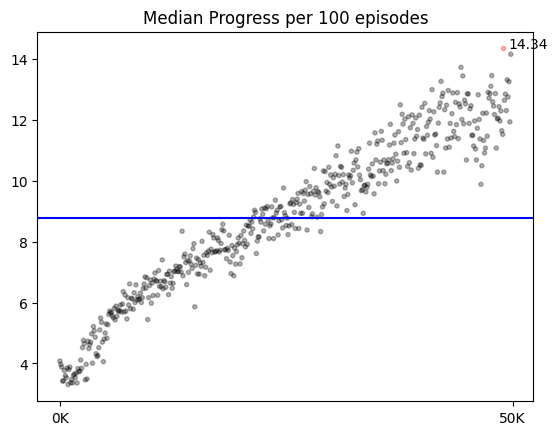

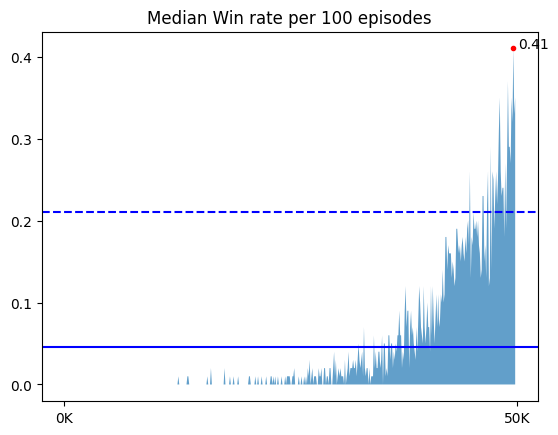

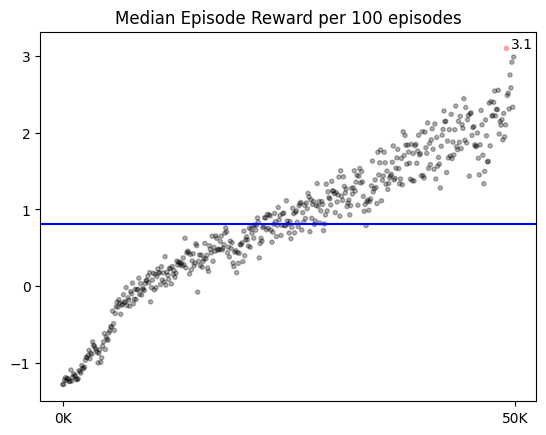

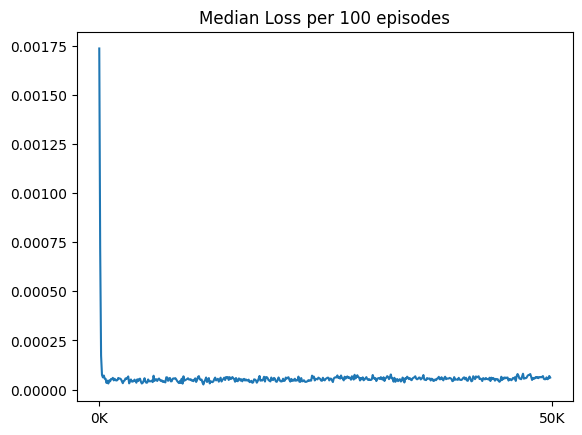

파일 '/content/drive/MyDrive/Minesweeper [RL]/models/basicModelWithBiasWithoutRule'가 생성되었습니다.
모델이 저장되었습니다.


In [ ]:
train = Trainer(env, agent, 'basicModelWithBiasWithoutRule')

In [25]:
with open('/content/drive/MyDrive/Minesweeper [RL]/models/basicModelWithBiasWithoutRule/200K.pkl', 'wb') as f:
    pickle.dump(train, f)

In [12]:
with open('/content/drive/MyDrive/Minesweeper [RL]/models/basicModelWithBiasWithoutRule/50K.pkl', 'rb') as f:
    t = pickle.load(f)

In [18]:
train = Trainer(env, agent, 'basicModelWithBiasWithoutRule',train_start=False)

In [19]:
train.agent = t.agent

train.agent.model.load_state_dict(t.agent.model.state_dict())
train.agent.target_model.load_state_dict(t.agent.target_model.state_dict())
train.agent.epsilon = t.agent.epsilon
train.agent.losses = t.agent.losses
train.progress_list = t.progress_list
train.wins_list = t.wins_list
train.ep_rewards_list = t.ep_rewards_list

train.best_model_train = t.best_model_train
train.best_model_valid = t.best_model_valid

train.baseline_train = t.baseline_train
train.baseline_valid = t.baseline_valid

Episode: [50000/100], Median progress: 13.50, Median reward: 3.00, Win rate : 0.44, Epsilon: 0.01
Episode: [50000/200], Median progress: 14.00, Median reward: 3.70, Win rate : 0.48, Epsilon: 0.01
Episode: [50000/300], Median progress: 12.00, Median reward: 2.40, Win rate : 0.36, Epsilon: 0.01
Episode: [50000/400], Median progress: 13.50, Median reward: 3.10, Win rate : 0.44, Epsilon: 0.01
Episode: [50000/500], Median progress: 13.00, Median reward: 2.95, Win rate : 0.46, Epsilon: 0.01
Episode: [50000/600], Median progress: 14.00, Median reward: 3.40, Win rate : 0.53, Epsilon: 0.01
Episode: [50000/700], Median progress: 14.00, Median reward: 3.00, Win rate : 0.46, Epsilon: 0.01
Episode: [50000/800], Median progress: 12.00, Median reward: 3.25, Win rate : 0.48, Epsilon: 0.01
Episode: [50000/900], Median progress: 14.00, Median reward: 2.80, Win rate : 0.40, Epsilon: 0.01
Episode: [50000/1000], Median progress: 14.00, Median reward: 3.40, Win rate : 0.49, Epsilon: 0.01
Episode: [50000/110

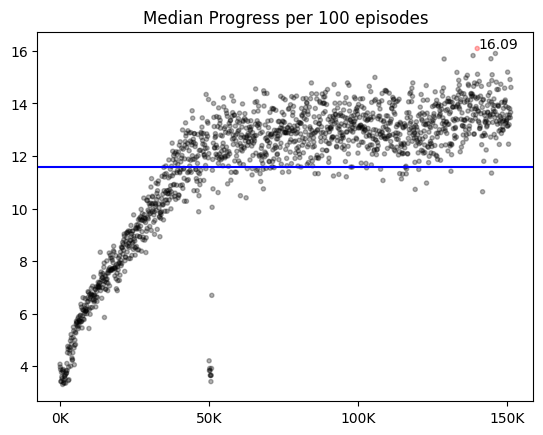

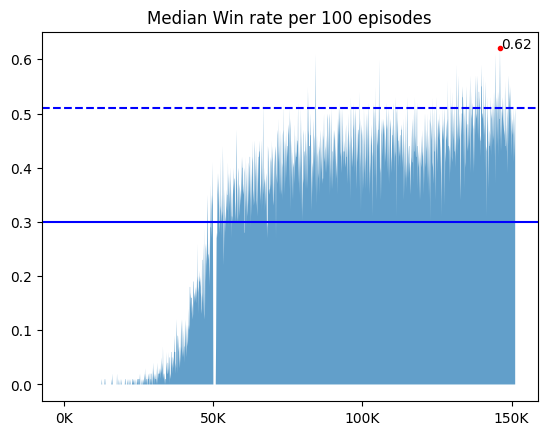

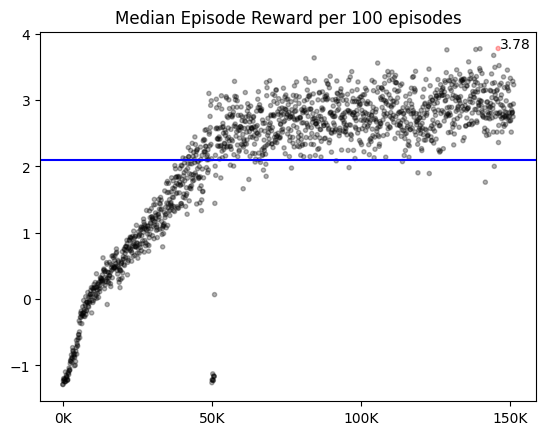

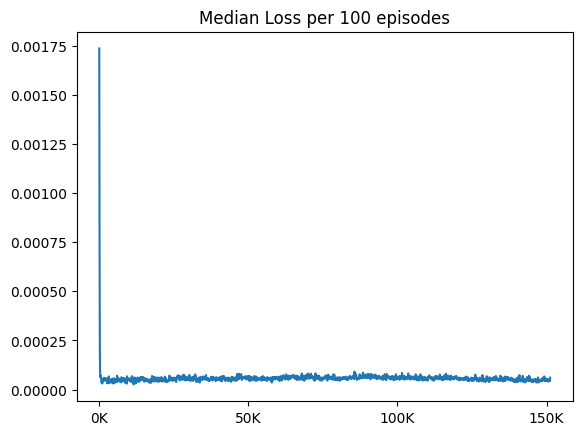

파일 '/content/drive/MyDrive/Minesweeper [RL]/models/basicModelWithBiasWithoutRule'는 이미 존재합니다.
모델이 저장되었습니다.


In [22]:
train.train()
train.visualize_train()
train.save_model()

Episode: [50000/100], Median progress: 15.00, Median reward: 3.15, Win rate : 0.47, Epsilon: 0.01
Episode: [50000/200], Median progress: 13.00, Median reward: 2.85, Win rate : 0.46, Epsilon: 0.01
Episode: [50000/300], Median progress: 15.50, Median reward: 3.75, Win rate : 0.52, Epsilon: 0.01
Episode: [50000/400], Median progress: 14.50, Median reward: 3.30, Win rate : 0.48, Epsilon: 0.01
Episode: [50000/500], Median progress: 15.00, Median reward: 4.00, Win rate : 0.59, Epsilon: 0.01
Episode: [50000/600], Median progress: 14.00, Median reward: 3.70, Win rate : 0.51, Epsilon: 0.01
Episode: [50000/700], Median progress: 14.00, Median reward: 3.25, Win rate : 0.53, Epsilon: 0.01
Episode: [50000/800], Median progress: 14.00, Median reward: 3.30, Win rate : 0.54, Epsilon: 0.01
Episode: [50000/900], Median progress: 14.00, Median reward: 3.10, Win rate : 0.46, Epsilon: 0.01
Episode: [50000/1000], Median progress: 15.00, Median reward: 3.30, Win rate : 0.48, Epsilon: 0.01
Episode: [50000/110

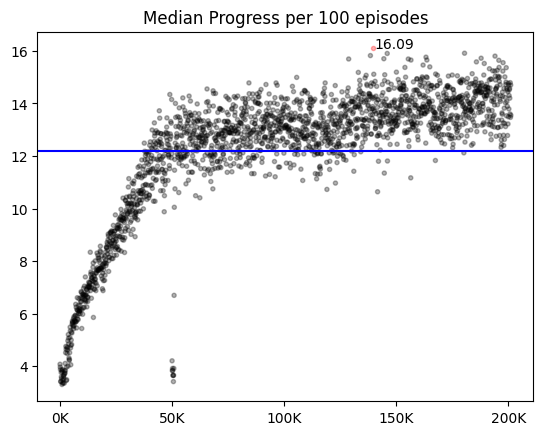

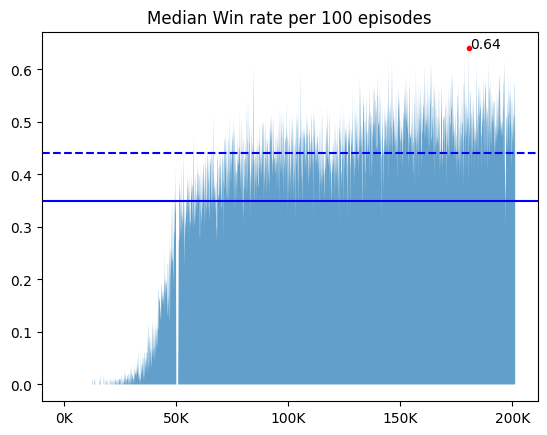

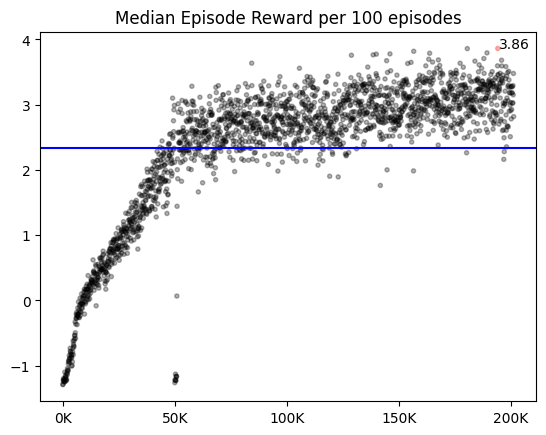

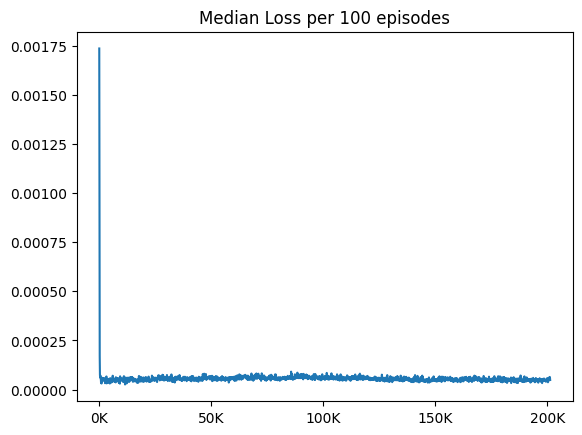

파일 '/content/drive/MyDrive/Minesweeper [RL]/models/basicModelWithBiasWithoutRule'는 이미 존재합니다.
모델이 저장되었습니다.


In [24]:
train.train()
train.visualize_train()
train.save_model()

# 03 Test